# BEE 4750 Homework 5: Mixed Integer and Stochastic Programming

**Name**:

**ID**:

> **Due Date**
>
> Thursday, 12/05/24, 9:00pm

## Overview

### Instructions

-   In Problem 1, you will use mixed integer programming to solve a
    waste load allocation problem.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/github/Cornell/BEE-5750/hw5-am3366_4`


In [2]:
using JuMP
using HiGHS
using DataFrames
using GraphRecipes
using Plots
using Measures
using MarkdownTables

## Problems (Total: 30 Points)

### Problem 1 (30 points)

Three cities are developing a coordinated municipal solid waste (MSW)
disposal plan. Three disposal alternatives are being considered: a
landfill (LF), a materials recycling facility (MRF), and a
waste-to-energy facility (WTE). The capacities of these facilities and
the fees for operation and disposal are provided below.

-   **LF**: Capacity 200 Mg, fixed cost \$2000/day, tipping cost
    \$50/Mg;
-   **MRF**: Capacity 350 Mg, fixed cost \$1500/day, tipping cost
    \$7/Mg, recycling cost \$40/Mg recycled;
-   **WTE**: Capacity 210 Mg, fixed cost \$2500/day, tipping cost
    \$60/Mg;

The MRF recycling rate is 40%, and the ash fraction of non-recycled
waste is 16% and of recycled waste is 14%. Transportation costs are
\$1.5/Mg-km, and the relative distances between the cities and
facilities are provided in the table below.

| **City/Facility** | **Landfill (km)** | **MRF (km)** | **WTE (km)** |
|:-----------------:|:-----------------:|:------------:|:------------:|
|         1         |         5         |      30      |      15      |
|         2         |        15         |      25      |      10      |
|         3         |        13         |      45      |      20      |
|        LF         |        \-         |      32      |      18      |
|        MRF        |        32         |      \-      |      15      |
|        WTE        |        18         |      15      |      \-      |

The fixed costs associated with the disposal options are incurred only
if the particular disposal option is implemented. The three cities
produce 100, 90, and 120 Mg/day of solid waste, respectively, with the
composition provided in the table below.

**Reminder**: Use `round(x; digits=n)` to report values to the
appropriate precision!

**In this problem**:

-   Formulate the waste load allocation problem and implement it in
    `JuMP`.
-   Draw a diagram showing the flows of waste between the cities and the
    facilities. Which facilities (if any) will not be used? Does this
    solution make sense?

### <font color='blue'> **Solution - Problem 1** </font>

We will formulate the waste load allocation problem. Our objective function will be minimizing the cost of our waste disposal plan. The cost components are fixed disposal costs, variable disposal costs, and transportation costs. 

We define our variables as follows: Let $W_{ij}$ be the waste transported from city $i$ to disposal $j$ in Mg/day. Let $R_{kj}$ be the residual waste transported from disposal $k$ to disposal $j$ in Mg/day. Let $Y_j$ be the operational status of disposal $j$. Let $c_j$ be the fixed cost of operating disposal $j$ in $/day. Let $b_j$ be the variable cost of disposing waste at disposal $j$ in $/Mg. Let $Y_j$ be an indicator variable for evaluating whether to operate disposal facility $j$, where $Y_j = 0$ if $\sum_{i \in I} W_{ij} = 0$ and $Y_j = 1$ if $\sum_{i \in I} W_{ij} > 0$.  Let $a_{ij}$ be the cost of transporting waste from source $i$ to disposal $j$ in $/Mg-km. Let $l_{ij}$ be the distance between source $i$ and disposal $j$ in km. Then we have: 
$$\textrm{Disposal costs: } \sum_{j \in J} [c_j + b_j \sum_{i \in I} W_{ij}]$$
$$\textrm{Transportation costs: } \sum_{i \in I} \sum_{j \in J} a_{ij} l_{ij} W_{ij}$$
$$\textrm{Total cost of waste disposal: } \sum_{i \in I} \sum_{j \in J} a_{ij} l_{ij} W_{ij} + \sum_{j \in J} [c_j + b_j \sum_{i \in I} W_{ij}]$$

Substituting the numbers from this problem into our equations, we get the following:
- Disposal cost for LF (1): $2000 Y_1 + 50(W_{11} + W_{21} + W_{31} + R_{21} + R_{31})$ 
- Disposal cost for MRF (2): $1500 Y_2 + (7 + 0.4 \times 40)(W_{12} + W_{22} + W_{32})$
- Disposal cost for WTE (3): $2500 Y_3 + 60(W_{13} + W_{23} + W_{33} + R_{23})$
- Transportation costs: $1.5(5W_{11} + 30W_{12} + 15W_{13} + 15W_{21} + 25W_{22} + 10W_{32} + 13W_{31} + 45W_{23} + 20W_{33} + 15R_{23} + 32R_{21} + 18R_{31})$
- Combined disposal and transportation costs: $2000 Y_1 + 50(W_{11} + W_{21} + W_{31} + R_{21} + R_{31}) + 1500 Y_2 + (7 + 0.4 \times 40)(W_{12} + W_{22} + W_{32}) + 2500 Y_3 + 60(W_{13} + W_{23} + W_{33} + R_{23}) + 1.5(5W_{11} + 30W_{12} + 15W_{13} + 15W_{21} + 25W_{22} + 10W_{32} + 13W_{31} + 45W_{23} + 20W_{33} + 15R_{23} + 32R_{21} + 18R_{31})$ 
- Distributing multiplication: $2000 Y_1 + 1500 Y_2 + 2500 Y_3 + 50W_{11} + 50W_{21} + 50W_{31} + 50R_{21} + 50R_{31} + 23W_{12} + 23W_{22} + 23W_{32}  + 60W_{13} + 60W_{23} + 60W_{33} + 60R_{23} + 7.5W_{11} + 45W_{12} + 22.5W_{13} + 22.5W_{21} + 37.5W_{22} + 15W_{32} + 19.5W_{31} + 67.5W_{23} + 30W_{33} + 22.5R_{23} + 48R_{21} + 27R_{31}$ 

**Objective function, for minimizing cost of waste disposal plan**: $\min 2000 Y_1 + 1500 Y_2 + 2500 Y_3 + 57.5W_{11} + 72.5W_{21} + 69.5W_{31} + 68W_{12} + 60.5W_{22} + 90.5W_{32} + 82.5W_{13} + 75W_{23} + 90W_{33} + 98R_{21} + 77R_{31} + 82.5R_{23}$ 

subject to the following constraints:
$$\textrm{City mass-balance constraints: } $$
$$W_{11} + W_{12} + W_{13} = 100$$
$$W_{21} + W_{22} + W_{23} = 90$$
$$W_{31} + W_{32} + W_{33} = 120$$

$$\textrm{Residual mass-balance constraints: } $$
$$R_{21} + R_{23} = 0.6(W_{12} + W_{22} + W_{32})$$
$$R_{31} = 0.16(W_{13} + W_{23} + W_{33}) + 0.14(R_{23})$$

$$\textrm{Disposal limit constraints: }$$
$$\textrm{LF: } W_{11} + W_{21} + W_{31} + R_{21} + R_{31} \leq 200$$
$$\textrm{MRF: } W_{12} + W_{22} + W_{32} \leq 350$$
$$\textrm{WTE: } W_{13} + W_{23} + W_{33} + R_{23} \leq 210$$

$$\textrm{Commitment and non-negativity constraints: }$$
$$Y_1 = 1$$
$$Y_2 = \begin{cases} 0 \textrm{ if } W_{12} + W_{22} + W_{32} = 0 \\
1 \textrm{ else } \end{cases}$$
$$Y_3 = \begin{cases} 0 \textrm{ if } W_{13} + W_{23} + W_{33} + R_{23} = 0 \\
1 \textrm{ else } \end{cases}$$
$$W_{ij}, R_{ij} \geq 0$$

Implementing this problem in JuMP below, we get that the cost of the waste disposal plan in our optimal solution is \$27,792.85.

In [3]:
waste_model = Model(HiGHS.Optimizer) # initialize model object
@variable(waste_model, W[i=1:3, j=1:3] >= 0) # non-negativity constraints
@variable(waste_model, R[j=1:3, k=1:3] >= 0) # non-negativity constraints
@variable(waste_model, Y[i=1:3], Bin) # non-negativity constraints

3-element Vector{VariableRef}:
 Y[1]
 Y[2]
 Y[3]

In [4]:
@objective(waste_model, Min, sum([2000; 1500; 2500] .* Y) + sum([57.5 68 82.5; 72.5 60.5 75; 69.5 90.5 90] .* W) + sum([0 0 0; 98 0 82.5; 77 0 0] .* R))

2000 Y[1] + 1500 Y[2] + 2500 Y[3] + 57.5 W[1,1] + 72.5 W[2,1] + 69.5 W[3,1] + 68 W[1,2] + 60.5 W[2,2] + 90.5 W[3,2] + 82.5 W[1,3] + 75 W[2,3] + 90 W[3,3] + 98 R[2,1] + 77 R[3,1] + 82.5 R[2,3]

In [5]:
@constraint(waste_model, city_1, sum(W[1,:]) == 100) 
@constraint(waste_model, city_2, sum(W[2,:]) == 90) 
@constraint(waste_model, city_3, sum(W[3,:]) == 120) 
@constraint(waste_model, residual_2, R[2,1] + R[2,3] == 0.6*(W[1,2] + W[2,2] + W[3,2])) 
@constraint(waste_model, residual_3, R[3,1] == 0.16*(W[1,3] + W[2,3] + W[3,3]) + 0.14*(R[2,3])) 
@constraint(waste_model, disposal_1, W[1,1] + W[2,1] + W[3,1] + R[2,1] + R[3,1] <= 200)
@constraint(waste_model, disposal_2, W[1,2] + W[2,2] + W[3,2] <= 350)
@constraint(waste_model, disposal_3, W[1,3] + W[2,3] + W[3,3] + R[2,3] <= 210)
@constraint(waste_model, commitment_1, 1000Y[1] >= W[1,1] + W[2,1] + W[3,1] + R[2,1] + R[3,1])
@constraint(waste_model, commitment_2, 1000Y[2] >= W[1,2] + W[2,2] + W[3,2])
@constraint(waste_model, commitment_3, 1000Y[3] >= W[1,3] + W[2,3] + W[3,3] + R[2,3])
@constraint(waste_model, commitment_4, R[1,1] + R[1,2] + R[1,3] + R[2,2] + R[3,2] + R[3,3]== 0)

commitment_4 : R[1,1] + R[1,2] + R[2,2] + R[3,2] + R[1,3] + R[3,3] = 0

In [6]:
optimize!(waste_model)

Running HiGHS 1.8.1 (git hash: 4a7f24ac6): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-01, 1e+03]
  Cost   [6e+01, 2e+03]
  Bound  [1e+00, 1e+00]
  RHS    [9e+01, 4e+02]
Presolving model
10 rows, 15 cols, 43 nonzeros  0s
8 rows, 13 cols, 35 nonzeros  0s

Solving MIP model with:
   8 rows
   13 cols (2 binary, 0 integer, 0 implied int., 11 continuous)
   35 nonzeros
MIP-Timing:     0.00029 - starting analytic centre calculation

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic; L => Sub-MIP;
     P => Empty MIP; R => Randomized rounding; S => Solve LP; T => Evaluate node; U => Unbounded;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

      

In [7]:
@show objective_value(waste_model)

objective_value(waste_model) = 27792.857142857138


27792.857142857138

In [8]:
@show value.(W)

value.(W) = [100.0 0.0 0.0; -0.0 -0.0 90.0; 79.04761904761905 0.0 40.95238095238089]


3×3 Matrix{Float64}:
 100.0      0.0   0.0
  -0.0     -0.0  90.0
  79.0476   0.0  40.9524

In [9]:
@show value.(R)

value.(R) = [0.0 0.0 0.0; 0.0 0.0 0.0; 20.952380952380942 0.0 0.0]


3×3 Matrix{Float64}:
  0.0     0.0  0.0
  0.0     0.0  0.0
 20.9524  0.0  0.0

In [10]:
@show value.(Y)

value.(Y) = [1.0, -0.0, 1.0]


3-element Vector{Float64}:
  1.0
 -0.0
  1.0

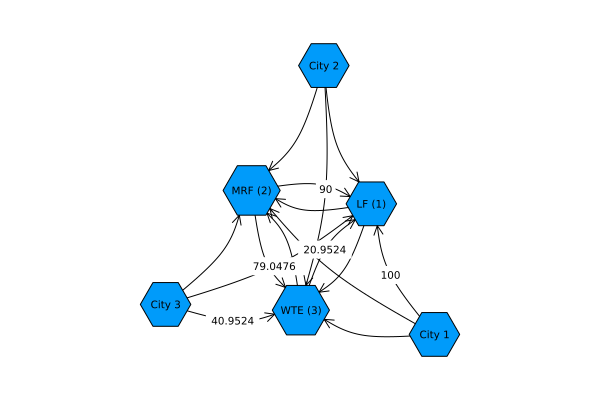

In [15]:
A = [0 0 0 1 1 1;
    0 0 0 1 1 1;
    0 0 0 1 1 1;
    0 0 0 0 1 1;
    0 0 0 1 0 1;
    0 0 0 1 1 0]

names = ["City 1", "City 2", "City 3", "LF (1)", "MRF (2)", "WTE (3)"]

edge_labels = Dict((1, 4) => "100", (2,6) => "90", (3,4) => 79.0476, (3,6) => 40.9524, (6,4) => 20.9524)

p = graphplot(A, names=names, edgelabel=edge_labels)
display(p)

## References

List any external references consulted, including classmates.